### Check differentiability of the code!

This notebook checks that the differentiability of the code.

The goal is to use autodofferentiation to find an initial condition that generated the final data. This is done by backprobagating through the entire solver (informally considered a physics constrained NN with a multipass ETDRK structure).

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import grad, jit, vmap
# import jaxopt

config.update("jax_enable_x64", True)

float64


Here we specify some final condition, by solving the model with a predefined initial condition.

In [ ]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
key = jax.random.PRNGKey(0)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key)

# one couls similarly just manually give a final condition.
#final = jnp.sin(2*jnp.pi*signal_model.x) 


Here we minimise the forward model at the final time step with respect to the initial condition

In [3]:
forward_model_params = ConfigDict(KDV_params_2)
forward_model_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
forward_model = ETD_KT_CM_JAX_Vectorised(signal_params)

# Randomly initialize the initial conditions for the forward model
key = jax.random.PRNGKey(0)
random_initial_conditions = initial_signal + 0.2*jnp.sin(8*jnp.pi*signal_model.x) + 0.2*jnp.sin(16*jnp.pi*signal_model.x)

# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.params.nt, None,key)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
grad_loss_fn = grad(loss_fn)

# Perform gradient descent to minimize the loss
learning_rate = 0.001
num_iterations = 10
optimized_initial_conditions = random_initial_conditions
for i in range(num_iterations):
    loss = loss_fn(optimized_initial_conditions)
    print(f"Iteration {i}, Loss: {loss}")
    gradients = grad_loss_fn(optimized_initial_conditions)
    optimized_initial_conditions -= learning_rate * gradients

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.200645533128077
Iteration 1, Loss: 6.115352422920503
Iteration 2, Loss: 6.09085057719177
Iteration 3, Loss: 6.0619356981745645
Iteration 4, Loss: 6.023478555626024
Iteration 5, Loss: 5.964294548971218
Iteration 6, Loss: 5.891634274517665
Iteration 7, Loss: 5.83895352301849
Iteration 8, Loss: 5.806160962926289
Iteration 9, Loss: 5.734798531808235


In [5]:
# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
@jit
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.params.nt, None, key)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
@jit
def compute_gradients(initial_conditions):
    return grad(loss_fn)(initial_conditions)

# Perform gradient descent to minimize the loss
@jit
def optimize(initial_conditions, learning_rate):
    gradients = compute_gradients(initial_conditions)
    updated_conditions = initial_conditions - learning_rate * gradients
    loss = loss_fn(updated_conditions)
    return updated_conditions, loss

# Initialize variables for optimization
optimized_initial_conditions = random_initial_conditions
learning_rate = 0.001
num_iterations = 10
# Optimization loop
for i in range(num_iterations):
    optimized_initial_conditions, loss = optimize(optimized_initial_conditions, learning_rate)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.115352422920561
Iteration 1, Loss: 6.090850577191891
Iteration 2, Loss: 6.061935698174643
Iteration 3, Loss: 6.023478555626143
Iteration 4, Loss: 5.964294548971637
Iteration 5, Loss: 5.891634274517972
Iteration 6, Loss: 5.838953523017508
Iteration 7, Loss: 5.806160962922484
Iteration 8, Loss: 5.734798531795041
Iteration 9, Loss: 5.4441896820131435


Here we use more advanced optax optimisation. 

In [11]:
import optax
# Define the optimizer
learning_rate = 0.001# note will only learn to about this precsion
optimizer = optax.adam(learning_rate, b1=0.9, b2=0.999, eps=1e-8)

# Initialize the optimizer state
opt_state = optimizer.init(random_initial_conditions)
num_iterations = 200
# Optimization loop using Adam
optimized_initial_conditions = random_initial_conditions

for i in range(num_iterations):
    loss, gradients = jax.value_and_grad(loss_fn)(optimized_initial_conditions)
    updates, opt_state = optimizer.update(gradients, opt_state)
    optimized_initial_conditions = optax.apply_updates(optimized_initial_conditions, updates)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.2006455331281165
Iteration 1, Loss: 6.112592046165045
Iteration 2, Loss: 6.09125462405275
Iteration 3, Loss: 6.0587148112909865
Iteration 4, Loss: 6.017877721754096
Iteration 5, Loss: 5.981423317939347
Iteration 6, Loss: 5.921941787256829
Iteration 7, Loss: 5.854452432124344
Iteration 8, Loss: 5.771216308328775
Iteration 9, Loss: 5.6585829123836735
Iteration 10, Loss: 5.522623012229717
Iteration 11, Loss: 5.349449389488003
Iteration 12, Loss: 5.140284696792177
Iteration 13, Loss: 4.914036717413162
Iteration 14, Loss: 4.693719154496744
Iteration 15, Loss: 4.524993813025301
Iteration 16, Loss: 4.454204738787575
Iteration 17, Loss: 4.4773773410481175
Iteration 18, Loss: 4.53367923321557
Iteration 19, Loss: 4.5627609173214285
Iteration 20, Loss: 4.541271314975315
Iteration 21, Loss: 4.47393386192038
Iteration 22, Loss: 4.379499335884296
Iteration 23, Loss: 4.283271039760404
Iteration 24, Loss: 4.209374603149329
Iteration 25, Loss: 4.168300814565035
Iteration 26, Loss: 

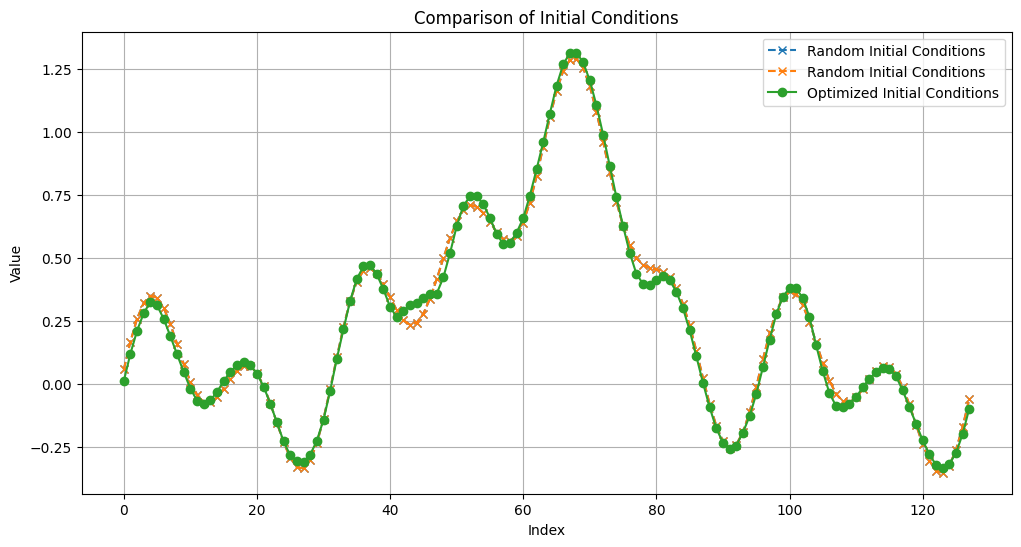

In [12]:
plt.figure(figsize=(12, 6))
plt.plot()
plt.plot(random_initial_conditions[-1], label='Random Initial Conditions', linestyle='--', marker='x')
plt.plot(random_initial_conditions[0], label='Random Initial Conditions', linestyle='--',marker='x')

# Plot optimized initial conditions
plt.plot(optimized_initial_conditions[-1], label='Optimized Initial Conditions', linestyle='-',marker='o')

plt.title('Comparison of Initial Conditions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

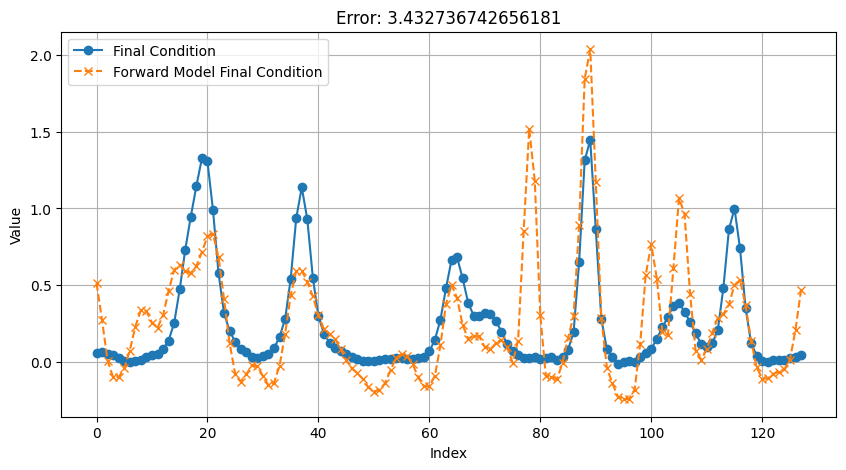

In [13]:
new_initial_conditions = optimized_initial_conditions
# Run the forward model with the optimized initial conditions
forward_final, all_rerun = signal_model.run(new_initial_conditions, forward_model.params.nt, None,key)

plt.figure(figsize=(10, 5))
plt.plot(final[0], label='Final Condition', linestyle='-', marker='o')
plt.plot(forward_final[0], label='Forward Model Final Condition', linestyle='--', marker='x')
plt.title('Final Condition')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Error: ' + str(jnp.linalg.norm(forward_final - final)))
plt.show()